<a href="https://colab.research.google.com/github/IsraelAbebe/ml-algorithems-from-scratch/blob/master/additional/MNIST_GDA_vs_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn import datasets,metrics
from matplotlib import pyplot
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys


Using TensorFlow backend.


In [0]:
examples = 20
from_class = 2

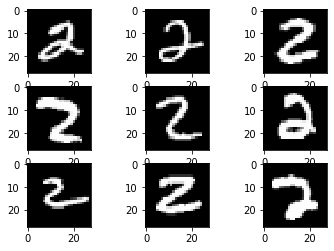

In [3]:
select_test_top = 7000
select_test_top = 1000

(trainX, trainy), (testX, testy) = mnist.load_data()
trainX, trainy, testX, testy  = trainX[:select_test_top], trainy[:select_test_top].reshape(-1,1) , testX[:select_test_top],testy[:select_test_top].reshape(-1,1)




example_images = []
count = 0

while True:
	for i,j in zip(trainX, trainy):
		if j == from_class:
			example_images.append(i)
	count += 1

	if count == examples:
		break
	 
	 
example_images = np.array(example_images)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(example_images[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

The data we are going to talk about

# **GDA**

In [0]:
class GDA():
    def __init__(self,train_data,label_data):
        self.train_data = train_data
        self.label_data = label_data
         
    def get_phi(self,i):
        return np.sum(self.label_data==i)/len(self.label_data)
    
    def get_mui(self,i=0):
        return  np.sum((self.label_data==i)*self.train_data,axis=0)/np.sum(self.label_data==i)
    
    def get_sigma(self):
        features = len(self.train_data[0])
        sigma = np.zeros((features,features)) 
        for train,label in zip(self.train_data,self.label_data):
            values = train-self.get_mui(i=float(label))   
            values = values.reshape(-1,1)
            values[np.isnan(values)] = 0
            cov_value = values*values.T
            sigma += cov_value
                
            sigma = sigma + cov_value
        return sigma/len(self.train_data)
    
    def get_predictions(self,data):
        cov = self.get_sigma()
        det  = np.linalg.det(cov)
        classes = np.unique(self.label_data)
        
        pred = []
        for i in classes:
            phi = self.get_phi(i)
            
            if det < 1e-5:
                det = 1

            sigma_inv = np.linalg.pinv(cov)
            mui = self.get_mui(i=i)
            value = (data-mui)
            first = 1/(((2*np.pi)**(len(classes)/2))*np.sqrt(det))
            
            result = first*np.exp((-1/2)*np.dot(np.dot(value,sigma_inv),value.T))
            pred.append(result)
            
        return pred, np.argmax(pred)
    
    def evaluate(self,data,label):
        pred = []
        for i in data:
            _,p = self.get_predictions(i)
            pred.append(p)
            
        return metrics.accuracy_score(pred,label)
        

In [0]:
def generate_sample(trainX,trainy,class_num,examples,visualize=10):
  gda = GDA(trainX.reshape(-1,28*28), trainy)
  mu, sigma = gda.get_mui(class_num),gda.get_sigma()

  samples_array = []
  for i in range(examples):
    samples = np.random.normal(mu, np.abs(sigma), 28*28)
    samples_array.append(samples)

  samples_array = np.array(samples_array)
  return samples_array



**Generated Pictures**

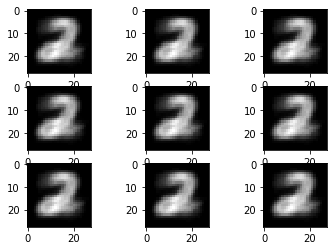

In [6]:
examples = 20
from_class = 2
samples_array = generate_sample(trainX,trainy,from_class,examples)
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(samples_array[i].reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()

**Real Pictures**

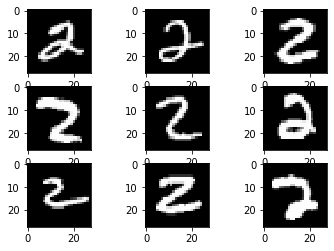

In [7]:
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(example_images[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# **GAN**

Adopted From:  github.com/eriklindernoren/Keras-GAN

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self,epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        return gen_imgs

In [9]:
gan = GAN()
gan.train(epochs=20000)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.544147, acc.: 57.03%] [G loss: 0.628061]
1 [D loss: 0.468918, acc.: 62.50%] [G loss: 0.712745]
2 [D loss: 0.370883, acc.: 76.56%] [G loss: 0.894008]
3 [D loss: 0.269883, acc.: 92.19%] [G loss: 1.075820]
4 [D loss: 0.225798, acc.: 98.83%] [G loss: 1.199468]
5 [D loss: 0.194195, acc.: 99.61%] [G loss: 1.336441]
6 [D loss: 0.172509, acc.: 100.00%] [G loss: 1.455797]
7 [D loss: 0.165407, acc.: 98.83%] [G loss: 1.565526]
8 [D loss: 0.134824, acc.: 100.00%] [G loss: 1.688213]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9 [D loss: 0.120609, acc.: 100.00%] [G loss: 1.782657]
10 [D loss: 0.111383, acc.: 100.00%] [G loss: 1.876241]
11 [D loss: 0.104290, acc.: 100.00%] [G loss: 1.966842]
12 [D loss: 0.087050, acc.: 100.00%] [G loss: 2.038342]
13 [D loss: 0.091193, acc.: 100.00%] [G loss: 2.117735]
14 [D loss: 0.084664, acc.: 100.00%] [G loss: 2.225448]
15 [D loss: 0.077905, acc.: 100.00%] [G loss: 2.296611]
16 [D loss: 0.073527, acc.: 100.00%] [G loss: 2.377614]
17 [D loss: 0.063462, acc.: 100.00%] [G loss: 2.435945]
18 [D loss: 0.056950, acc.: 100.00%] [G loss: 2.550911]
19 [D loss: 0.058395, acc.: 100.00%] [G loss: 2.560485]
20 [D loss: 0.051416, acc.: 100.00%] [G loss: 2.674073]
21 [D loss: 0.044552, acc.: 100.00%] [G loss: 2.677052]
22 [D loss: 0.041402, acc.: 100.00%] [G loss: 2.781807]
23 [D loss: 0.042935, acc.: 100.00%] [G loss: 2.860806]
24 [D loss: 0.039938, acc.: 100.00%] [G loss: 2.866519]
25 [D loss: 0.039610, acc.: 100.00%] [G loss: 2.948246]
26 [D loss: 0.040615, acc.: 100.00%] [G loss: 2.9

In [0]:
images = gan.sample_images(epoch=100) 

In [0]:
images = images.reshape(-1,28,28)

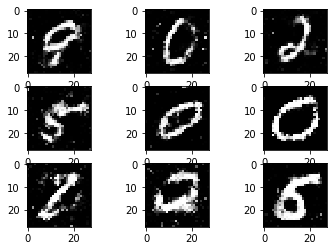

In [22]:
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(images[i].reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()